In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
#Get all data ready
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1647449098/' #Averaged
import pandas as pd
df = pd.read_pickle(path+'predictions.pkl')

df_tmp = df.copy()
df_tmp['error_ERA'] = abs(df_tmp.MODIS_LST - df_tmp.t2m)
df_tmp['error_NN'] = abs(df_tmp.MODIS_LST - df_tmp.predictions)
df_tmp['error_ERA_rel'] = abs(df_tmp.MODIS_LST - df_tmp.t2m) / df_tmp.MODIS_LST
df_tmp['error_NN_rel'] = abs(df_tmp.MODIS_LST - df_tmp.predictions) / df_tmp.MODIS_LST
df_tmp["time_daily"] = df_tmp['time'].dt.to_period('D').dt.to_timestamp()
ds_map = df_tmp.groupby(['latitude_ERA', 'longitude_ERA','time_daily'],as_index=False).mean()

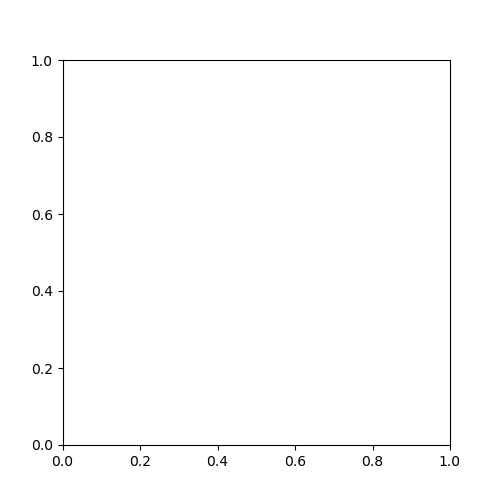

In [6]:

# Set parameters
frames = 10

# Data for plotting
t = np.unique(ds_map.time_daily)


# init the figure
fig, ax = plt.subplots(figsize=(5,5))

def update(i):
    # clear the axis each frame
    ax.clear()

    
    #Get the data
    ti=t[i]
    condition = f"time_daily == '{ti}'"
    ds = ds_map.query(condition)
    
    x = ds.longitude_ERA
    y = ds.latitude_ERA
    z = ds['error_ERA']
        
    
    # replot things
    sc = ax.scatter(x, y,
               s=1,
               c=z,
               cmap='viridis',
               )
    #cbar = plt.colorbar(sc)
    #cbar.ax.set_ylabel('X', rotation=270,fontsize = 12)
    #plt.clim(0,10)

    # reformat things
    ax.set_xlabel('world')
    ax.set_ylabel('hello')

ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)
#HTML(ani.to_jshtml())

/home/k/kimpson/bin/conda/envs/GPU/lib/python3.7/site-packages/matplotlib/animation.py:890: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  'Animation was deleted without rendering anything. This is '


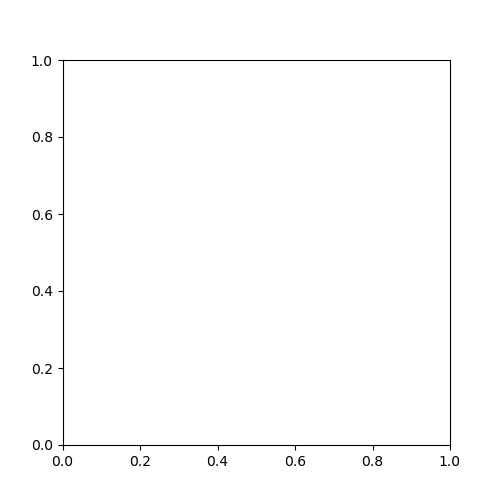

In [5]:
import itertools
# set parameters
frames = 10
points = 20
np.random.seed(42)

# create data
data = np.random.rand(points, 2)

# set how the graph will change each frame
sizes = itertools.cycle([10, 50, 150])
colors = np.random.rand(frames, points)
colormaps = itertools.cycle(['Purples', 'Blues', 'Greens', 'Oranges', 'Reds'])
markers = itertools.cycle(['o', 'v', '^', 's', 'p'])

# init the figure
fig, ax = plt.subplots(figsize=(5,5))

def update(i):
    # clear the axis each frame
    ax.clear()

    # replot things
    ax.scatter(data[:, 0], data[:, 1],
               s=next(sizes),
               c=colors[i, :],
               cmap=next(colormaps),
               marker=next(markers))

    # reformat things
    ax.set_xlabel('world')
    ax.set_ylabel('hello')

ani = animation.FuncAnimation(fig, update, frames=frames, interval=500)

[<AxesSubplot:>, <Axes:>]
[<AxesSubplot:>, <Axes:>, <Axes:label='<colorbar>'>]


/home/k/kimpson/bin/conda/envs/GPU/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Text(0.5, 1.0, 't')

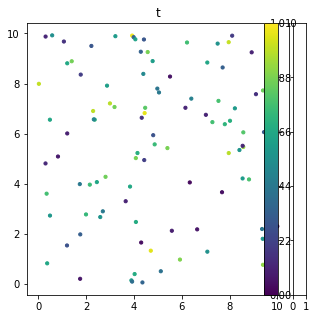

In [49]:

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


# init the figure
fig, ax = plt.subplots(figsize=(5,5))



divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


print(plt.gcf().get_axes())



#fig.clear()
#ax.set_ylim(0,10)

x = np.random.random(100)*10
y = np.random.random(100)*10
z = np.random.random(100)*10



   # colorbar_axes.remove()

sc = ax.scatter(x,y,s=10,c=z,cmap='viridis',vmin=0,vmax=10)

#Ax config


#cbar = fig.colorbar(sc, cax=cax, orientation='vertical')

cbar = fig.colorbar(sc)
print(plt.gcf().get_axes())
#cbar.clim(0,10)

#cbar.ax.set_ylabel('K', rotation=0,fontsize = 12)
ax.set_title('t')

# _, colorbar_axes = plt.gcf().get_axes()
# colorbar_axes.remove()
# print(colorbar_axes)

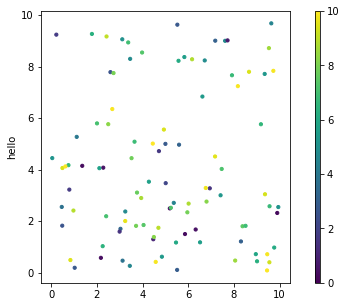

In [69]:
import matplotlib.colors as mc
import matplotlib.colorbar as cb


fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(5,5))


x = np.random.random(100)*10
y = np.random.random(100)*10
z = np.random.random(100)*10




cmap = plt.cm.viridis
norm = mc.Normalize(vmin=0, vmax=10)

cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')


def update(i):
    
   


    # clear the axis each frame
    ax.clear()
    # try:
    #     _, colorbar_axes = plt.gcf().get_axes()
    #     colorbar_axes.remove()
    # except:
    #     pass
    # print(plt.gcf().get_axes())
    

    sc = ax.scatter(x,y,s=10,c=cmap(norm(z)))


    #cbar = plt.colorbar(sc)
    ax.set_ylabel('hello')
    
for i in range(10):
    update(i)

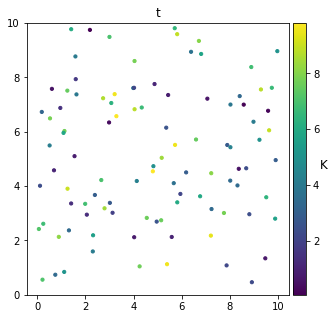

In [26]:
fig